# ECE 381K Applied Machine Learning Project (Group 10)

Use this playground to do EDA, feature/model selection, and run experiments! Make sure this notebook is self-contained.

List of cells for running project out-of-box:
 - [ ] pip freeze cell to get dependencies
 - [ ] CLEAR config management (try Hydra)
 - [ ] CLEAR hyperparameter tuning (try Optuna)
    - This can give some very nice plots for final report!
 - [ ] blah

## Acknowledgements

The authors acknowledge the following list of project notebooks and github repositories where they found motivation, or direct coding examples for this project.

- https://github.com/tubo213/kaggle-child-mind-institute-detect-sleep-states/tree/main


In [6]:
# from google.colab import drive

# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# ! pip install black
# ! pip install hydra-core --upgrade
! pip install vapeplot

  Created wheel for vapeplot: filename=vapeplot-0.0.8-py3-none-any.whl size=11013 sha256=c646bf3b30672708071023fc77edf871d255f603b635ade2bdde7edb99e805ff
  Stored in directory: /home/ss26/.cache/pip/wheels/fa/6f/61/605af43e7b50817833014c179327525e6552294ac0c5fb4fe5
Successfully built vapeplot


In [1]:
! which pip

/usr/bin/pip


In [81]:
# ALL imports go here

import os
import jupyter_black
from IPython.display import Markdown
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

from sklearn.svm import SVC

import numpy as np
import polars as pl

# plotting utils and default globals
import matplotlib.pyplot as plt
import seaborn as sns
import gc

plt.style.use("ggplot")

plt.rcParams.update({'font.size': 18,
          'legend.fontsize': 'medium',
          'axes.titleweight': 'bold',
          'axes.labelweight': 'bold',
         'axes.labelsize': 18,
         'axes.titlesize': 20,
         'xtick.labelsize': 16,
         'ytick.labelsize': 16})

# set this to true to save figures locally / download them from the colab notebook
# by default set it to false
SAVE_FIGURES = True

In [57]:
ROOT_DIR = "/home/ss26/Projects/detecting-sleep-states/"
DATA_DIR = ROOT_DIR + "/data/"
PLOTS_DIR = ROOT_DIR + "/plots/"

CHUNK_SIZE = 1_000_000


In [4]:
train_series = pl.read_parquet(DATA_DIR + "train_series.parquet", n_rows=CHUNK_SIZE)
train_events = pl.read_csv(DATA_DIR + "train_events.csv")

In [6]:
train_series.head()

series_id,step,timestamp,anglez,enmo
str,u32,str,f32,f32
"""038441c925bb""",0,"""2018-08-14T15:…",2.6367,0.0217
"""038441c925bb""",1,"""2018-08-14T15:…",2.6368,0.0215
"""038441c925bb""",2,"""2018-08-14T15:…",2.637,0.0216
"""038441c925bb""",3,"""2018-08-14T15:…",2.6368,0.0213
"""038441c925bb""",4,"""2018-08-14T15:…",2.6368,0.0215


In [7]:
train_events.head()

series_id,night,event,step,timestamp
str,i64,str,i64,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:…"
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:…"
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:…"
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:…"
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:…"


`train_events.csv` provides the actual **y** variable, _onset_ or _wakeup_. Make a concatenated dataset to connect `train_series.parquet` which has accelerometer data with `train_events.csv`

In [20]:
def get_train_series(series):
    train_series = pl.read_parquet(DATA_DIR + "train_series.parquet", n_rows=CHUNK_SIZE)
    train_series = train_series.filter(pl.col('series_id') == series)
    train_events = pl.read_csv(DATA_DIR + "train_events.csv")
    train_events = train_events.filter(pl.col('series_id') == series)

    # cleaning etc.
    train_events = train_events.drop_nulls()
    train_events = train_events.with_columns(pl.col("step").cast(pl.Int64))
    train_series = train_series.with_columns(pl.col("step").cast(pl.Int64))

    # print(train_series)

    train_events = train_events.with_columns(pl.col('event').map_dict(remapping={'onset': 0, 'wakeup': 1})).rename({'event': 'awake'})
    # print(train_events)
    

    train = train_series.join(train_events.select(['step','awake']), on='step', how='left')
    
    
    train = train.with_columns(pl.col("awake").fill_null(strategy='backward'))
    train = train.with_columns(pl.col("awake").fill_null(1))
    # # final section:
    # # train_events.groupby('series_id').tail(1)["event"].unique()
    # # Result: the last event is always a "wakeup"
    train = train.with_columns(pl.col("awake").cast(pl.Int64))
    
    return(train)

In [72]:
series_to_plot = ['038441c925bb', '292a75c0b94e']

### anglez for series 038441c925bb


/tmp/ipykernel_27493/2134583321.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(PLOTS_DIR + f'series_{series}_anglez_vs_timestep.png', bbox_inches='tight', dpi=200)


### enmo for series 038441c925bb


/tmp/ipykernel_27493/2134583321.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(PLOTS_DIR + f'series_{series}_enmo_vs_timestep.png', bbox_inches='tight', dpi=200)


### anglez for series 292a75c0b94e
### enmo for series 292a75c0b94e


/home/ss26/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


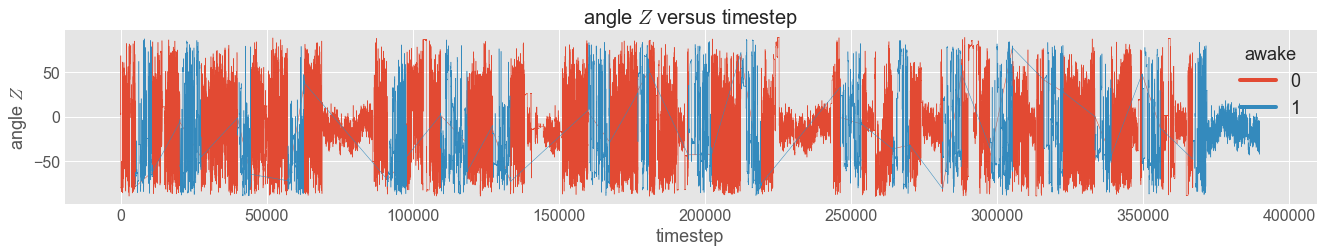

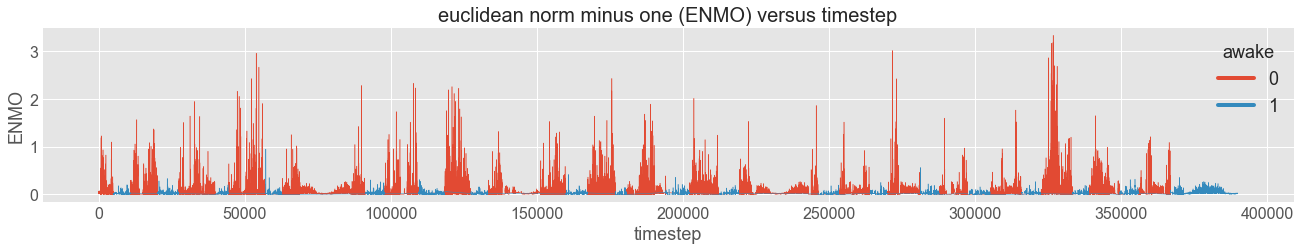

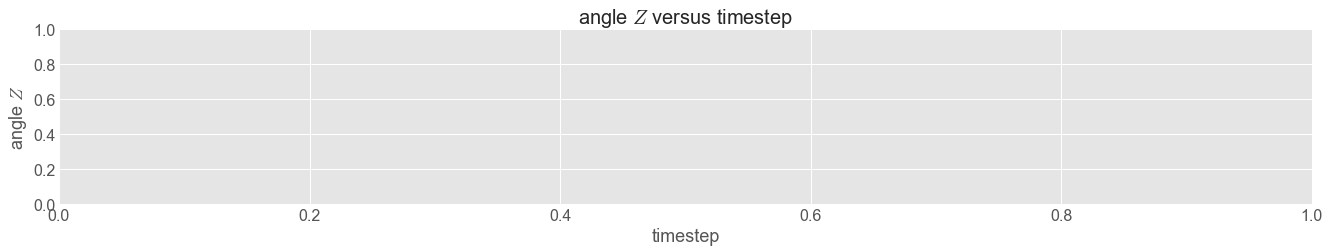

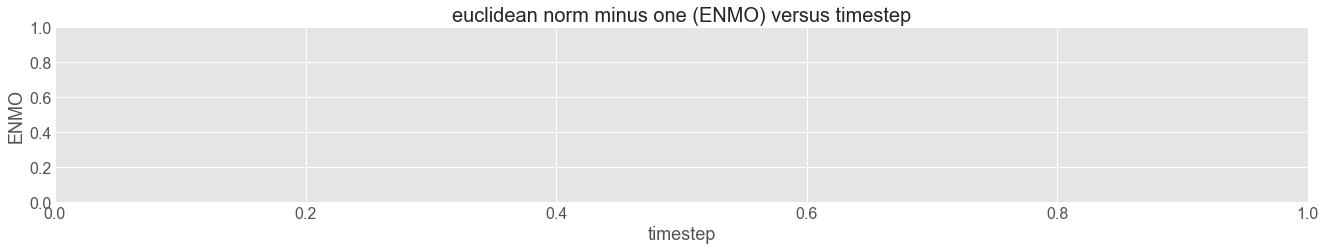

In [82]:
for series in series_to_plot:
    train = get_train_series(series)
    print('### anglez for series ' + series)
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.xlabel("timestep")
    plt.ylabel("angle $Z$")
    plt.title("angle $Z$ versus timestep")

    if SAVE_FIGURES:
        fig.savefig(PLOTS_DIR + f'series_{series}_anglez_vs_timestep.png', bbox_inches='tight', dpi=200)
    else:
        plt.show()

    print('### enmo for series ' + series)
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.xlabel("timestep")
    plt.ylabel("ENMO")
    plt.title("euclidean norm minus one (ENMO) versus timestep")

    if SAVE_FIGURES:
        fig.savefig(PLOTS_DIR + f'series_{series}_enmo_vs_timestep.png', bbox_inches='tight', dpi=200)
    else:
        plt.show()
        
    # del train
    # plt.gca()
    # gc.collect()